# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts, cross_val_score as cvs
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.seasonal import seasonal_decompose #Para descomponer la serie
from matplotlib import pyplot as plt #Gráficas
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RFR
from catboost import CatBoostRegressor as CBR

data= pd.read_csv('/datasets/taxi.csv')


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [3]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
data_og = data.copy()
data_og.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
data['datetime'] = data['datetime'].astype('datetime64')

In [6]:
data.set_index('datetime', inplace= True)
data.sort_index(inplace=True)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
data.index.is_monotonic_increasing #Verificamos que este en orden

True

In [8]:
data = data.resample('1H').sum() #Remuetreamos para intervalos de una hora.
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Análisis

Text(0.5, 1.0, 'Tendencia')

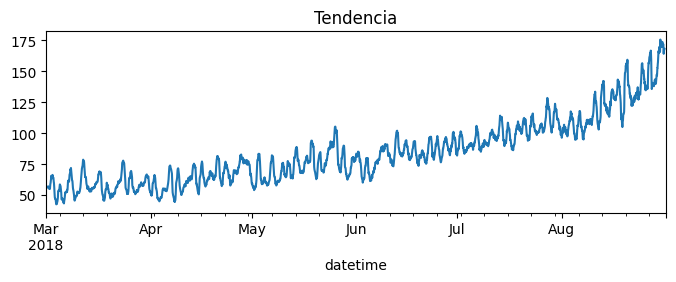

In [9]:
#Descomponemos la serie para encontrar estacionalidad, tendencia y residuos
decomposed = seasonal_decompose(data)
plt.figure(figsize=(8,8))
plt.subplot(311)
decomposed.trend.plot(ax= plt.gca())
plt.title('Tendencia')

Text(0.5, 1.0, 'Estacionalidad')

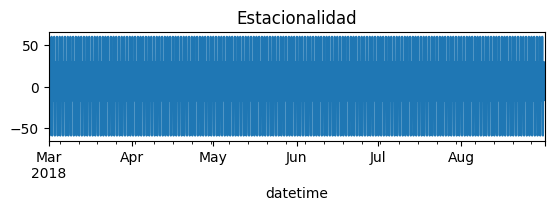

In [10]:
plt.subplot(312)
decomposed.seasonal.plot(ax= plt.gca())
plt.title('Estacionalidad')

Text(0.5, 1.0, 'Residuo')

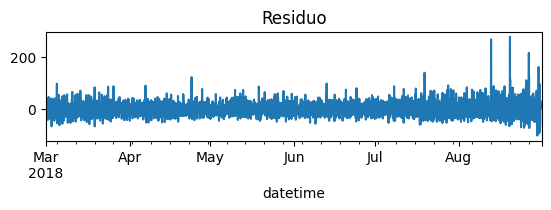

In [11]:
plt.subplot(313)
decomposed.resid.plot(ax= plt.gca())
plt.title('Residuo')

Vemos que la serie no es estacionaria ya que la tendencia aumenta con el tiempo

<AxesSubplot:xlabel='datetime'>

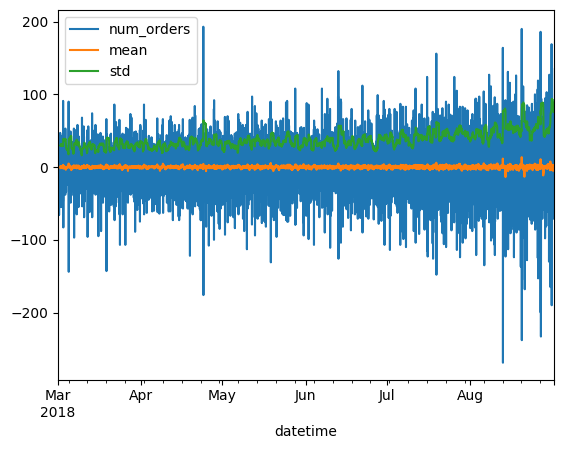

In [12]:
#Diferenciación de serie
data_dif = data.copy()
data_dif -= data_dif.shift()
data_dif['mean'] = data_dif['num_orders'].rolling(24).mean()
data_dif['std'] = data_dif['num_orders'].rolling(24).std()
data_dif.plot()
# La desviación empieza a fluctuar más en los meses recientes.

## Formación

In [13]:
#Generamos caracteristicas
def ft(df, max_lag, rolling_mean_size):
    df['month'] = data.index.month
    df['day'] = data.index.day
    df['dow'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = df.iloc[:,0].shift(lag)

    df['rolling_mean'] = df.iloc[:,0].rolling(rolling_mean_size).mean()

In [14]:
ft(data, 24, 24)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   month         4416 non-null   int64  
 2   day           4416 non-null   int64  
 3   dow           4416 non-null   int64  
 4   lag_1         4415 non-null   float64
 5   lag_2         4414 non-null   float64
 6   lag_3         4413 non-null   float64
 7   lag_4         4412 non-null   float64
 8   lag_5         4411 non-null   float64
 9   lag_6         4410 non-null   float64
 10  lag_7         4409 non-null   float64
 11  lag_8         4408 non-null   float64
 12  lag_9         4407 non-null   float64
 13  lag_10        4406 non-null   float64
 14  lag_11        4405 non-null   float64
 15  lag_12        4404 non-null   float64
 16  lag_13        4403 non-null   float64
 17  lag_14        4402 non-null

In [15]:
#Separamos conjunto de prueba y entrenamiento
data = data.dropna()
X = data.drop('num_orders', axis=1)
y = data['num_orders']

X_train, X_test, y_train, y_test = tts(X, y, test_size= .1, shuffle= False)

print(X_train.index.min(), X_train.index.max())
print(X_test.index.min(), X_test.index.max())

2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


In [16]:
#Entrenamos
lmodel = LR()

lscores = cvs(lmodel, X_train, y_train, cv= 5, scoring='neg_mean_squared_error')

print('Validación cruzada:')
print('ECMs negativos:', lscores)
print('RECMs promedio:', (-lscores.mean())**.5)
print('Desviación estandar ECMs:', lscores.std())

Validación cruzada:
ECMs negativos: [-1.19116179e-25 -1.21900109e-25 -1.22777161e-25 -4.99484965e-25
 -9.96318909e-25]
RECMs promedio: 6.098520020529577e-13
Desviación estandar ECMs: 3.448590119040877e-25


In [17]:
fmodel = RFR(random_state=123, max_depth= 9, n_estimators= 65)

fscores = cvs(fmodel, X_train, y_train, cv= 5, scoring='neg_mean_squared_error')

print('Validación de Bosque:')
print('ECMs negativos:', fscores)
print('RECMs promedio', (-fscores.mean())**.5)
print('Desviación estandar ECMs:', lscores.std())

Validación de Bosque:
ECMs negativos: [ -409.74291544  -442.93999722  -545.82527444  -607.95223699
 -1149.99388057]
RECMs promedio 25.125502202566203
Desviación estandar ECMs: 3.448590119040877e-25


In [18]:
#Catboost
gbm = CBR(random_seed= 123, iterations= 600, learning_rate= .15, depth= 10, verbose= 60)
gbm.fit(X_train, y_train)
#learn por defecto es RECM

0:	learn: 35.9718512	total: 69ms	remaining: 41.3s
60:	learn: 14.9448785	total: 1.36s	remaining: 12s
120:	learn: 9.7414441	total: 2.63s	remaining: 10.4s
180:	learn: 6.5139461	total: 3.92s	remaining: 9.08s
240:	learn: 4.5027012	total: 5.2s	remaining: 7.74s
300:	learn: 2.9993608	total: 6.47s	remaining: 6.43s
360:	learn: 2.1077372	total: 7.76s	remaining: 5.14s
420:	learn: 1.5185987	total: 9.05s	remaining: 3.85s
480:	learn: 1.0615525	total: 10.3s	remaining: 2.56s
540:	learn: 0.7830625	total: 11.6s	remaining: 1.27s
599:	learn: 0.5646291	total: 12.9s	remaining: 0us


## Prueba

In [21]:
#evaluar el modelo con una prediccón constante
pred_median = np.ones(y_test.shape) * y_train.median()
mse(y_test, pred_median)**.5

87.21093811714634

In [24]:
#Probar el modelo de regresión, ya que en este caso resulto ser el de menor error
lmodel.fit(X_train,y_train)
lmodel_pred = lmodel.predict(X_test)
rmse = mse(y_test, lmodel_pred)**.5
rmse

9.346914647560357e-13

In [ ]:
#Tenemos un error muy bajo por lo que el modelo funciona bien con la regresión lineal.

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x]  	
Los datos han sido descargados y preparados.
- [x]  Se ha realizado el paso 2: los datos han sido analizados
- [x]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x]  Se han evaluado los modelos. Se expuso una conclusión
- [x] La *RECM* para el conjunto de prueba no es más de 48